## necesssary dependency to install 

In [1]:
import pandas as pd
import numpy as np
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from collections import Counter
import re
from joblib import Parallel, delayed

##Descriptive Statistics


In [ ]:
# basic statistics for textual lengths
import pandas as pd
import numpy as np
from textblob import TextBlob

# Load data from a file (accepting the path)
file_path = "../assets/data/raw_analyst_ratings.csv"  # Replace 'your_dataset.csv' with the actual file path
df = pd.read_csv(file_path)

# Ensure the dataset has a 'headline' column
if 'headline' not in df.columns:
    raise ValueError("The dataset must contain a 'headline' column.")

# Calculate headline lengths (in characters and words)
df['length_characters'] = df['headline'].str.len()
df['length_words'] = df['headline'].str.split().apply(len)

# Basic statistics
stats = {
    'Total Headlines': len(df),
    'Average Length (Characters)': df['length_characters'].mean(),
    'Average Length (Words)': df['length_words'].mean(),   
    'Longest Headline (Characters)': df['length_characters'].max(),
    'Shortest Headline (Characters)': df['length_characters'].min(),
    'Longest Headline (Words)': df['length_words'].max(),
    'Shortest Headline (Words)': df['length_words'].min(),
}

# Print the DataFrame and statistics
print("Headline Data:")
print(df.head())  # Display the first few rows of the dataset
print("\nBasic Statistics:")
for stat, value in stats.items():
    print(f"{stat}: {value}")


Headline Data:
   Unnamed: 0                                           headline  \
0           0            Stocks That Hit 52-Week Highs On Friday   
1           1         Stocks That Hit 52-Week Highs On Wednesday   
2           2                      71 Biggest Movers From Friday   
3           3       46 Stocks Moving In Friday's Mid-Day Session   
4           4  B of A Securities Maintains Neutral on Agilent...   

                                                 url          publisher  \
0  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
1  https://www.benzinga.com/news/20/06/16170189/s...  Benzinga Insights   
2  https://www.benzinga.com/news/20/05/16103463/7...         Lisa Levin   
3  https://www.benzinga.com/news/20/05/16095921/4...         Lisa Levin   
4  https://www.benzinga.com/news/20/05/16095304/b...         Vick Meyer   

                        date stock  length_characters  length_words  
0  2020-06-05 10:30:54-04:00     A                 39  

In [ ]:

file_path = "../assets/data/raw_analyst_ratings.csv"  
df = pd.read_csv(file_path)
# Count articles per publisher
publisher_counts = df['publisher'].value_counts()

# Print articles per publisher
print("Articles per Publisher:")
print(publisher_counts)


Articles per Publisher:
publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
                      ...  
MoneyGeek                 1
muathe                    1
Robert Morris             1
LeftCoastHedgie           1
Jeremie Capron            1
Name: count, Length: 1034, dtype: int64


In [4]:
# analyze publication dates for trends over time:
if 'date' not in df.columns:
    raise ValueError("The dataset must contain a 'date' column.")
df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d %H:%M:%S", errors='coerce')

# Check for invalid dates
if df['date'].isnull().any():
    print("Warning: Some publication dates could not be parsed and were set to NaT.")
# Extract day of the week and year-month for analysis
df['day_of_week'] = df['date'].dt.day_name()
df['year_month'] = df['date'].dt.to_period('M')

# Count articles by day of the week
articles_by_day = df['day_of_week'].value_counts()

# Count articles by year-month
articles_by_month = df['year_month'].value_counts().sort_index()

# Print the trends
print("Articles by Day of the Week:")
print(articles_by_day)
print("\nArticles by Year-Month:")
print(articles_by_month)


Articles by Day of the Week:
day_of_week
Thursday     289907
Wednesday    289049
Tuesday      285468
Monday       254842
Friday       208511
Sunday        16078
Saturday       7486
Name: count, dtype: int64

Articles by Year-Month:
year_month
2009-02        1
2009-04        3
2009-05       12
2009-06       40
2009-07       75
           ...  
2020-02    16523
2020-03    20314
2020-04    16141
2020-05     8659
2020-06      457
Freq: M, Name: count, Length: 136, dtype: int64


## Text Analysis(Sentiment analysis & Topic Modeling):

In [6]:
# Load data from a CSV file
file_path = "../assets/data/raw_analyst_ratings.csv"  # Replace with the actual path to your file
df = pd.read_csv(file_path)

# Ensure the dataset has a 'headline' column
if 'headline' not in df.columns:
    raise ValueError("The dataset must contain a 'headline' column.")

# Perform sentiment analysis
def analyze_sentiment(headline):
    analysis = TextBlob(headline)
    polarity = analysis.polarity  # Sentiment polarity: -1 (negative) to +1 (positive)
    if polarity > 0:
        return "Positive"
    elif polarity < 0:
        return "Negative"
    else:
        return "Neutral"

# Apply the sentiment analysis function to the headlines
df['sentiment'] = df['headline'].apply(analyze_sentiment)

# Count the number of headlines by sentiment
sentiment_counts = df['sentiment'].value_counts()

# Print results
print("Sentiment Analysis Results:")
print(sentiment_counts)


Sentiment Analysis Results:
sentiment
Neutral     934914
Positive    341178
Negative    131236
Name: count, dtype: int64


In [ ]:
import pandas as pd
import spacy
from collections import Counter
from itertools import chain
from multiprocessing import Pool

# Load Data and Preprocessing
# Load spaCy's English language model (Disable unnecessary components)
nlp = spacy.load("en_core_web_sm", disable=["parser", "tagger"])

# Load data from a CSV file
file_path = "../assets/data/raw_analyst_ratings.csv"  # Replace with the actual path to your file
df = pd.read_csv(file_path)

# Ensure the dataset has a 'headline' column
if 'headline' not in df.columns:
    raise ValueError("The dataset must contain a 'headline' column.")

# Preprocess headlines (convert to lowercase, remove NaN)
df['headline'] = df['headline'].fillna('').str.lower()

# Display a sample of the data to verify the preprocessing
print(df.head())


   Unnamed: 0                                           headline  \
0           0            stocks that hit 52-week highs on friday   
1           1         stocks that hit 52-week highs on wednesday   
2           2                      71 biggest movers from friday   
3           3       46 stocks moving in friday's mid-day session   
4           4  b of a securities maintains neutral on agilent...   

                                                 url          publisher  \
0  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
1  https://www.benzinga.com/news/20/06/16170189/s...  Benzinga Insights   
2  https://www.benzinga.com/news/20/05/16103463/7...         Lisa Levin   
3  https://www.benzinga.com/news/20/05/16095921/4...         Lisa Levin   
4  https://www.benzinga.com/news/20/05/16095304/b...         Vick Meyer   

                        date stock  
0  2020-06-05 10:30:54-04:00     A  
1  2020-06-03 10:45:20-04:00     A  
2  2020-05-26 04:30:07-04:00 

In [4]:
# Function to process a batch of text
def process_text_batch(batch):
    docs = list(nlp.pipe(batch, batch_size=5000))  # Increase batch size for efficiency
    batch_keywords = []
    for doc in docs:
        keywords = [ent.text for ent in doc.ents]  # Extract only named entities for speed
        batch_keywords.append(keywords)
    return batch_keywords


In [5]:
# Load the dataset
file_path = "../assets/data/raw_analyst_ratings.csv"  # Replace with your actual file path
df = pd.read_csv(file_path)

# Ensure the dataset has a 'headline' column
if 'headline' not in df.columns:
    raise ValueError("The dataset must contain a 'headline' column.")


In [6]:
# Test processing with a small block of data (e.g., first 100 headlines)
test_batch = df['headline'][:100].tolist()

# Process the test batch
test_keywords = process_text_batch(test_batch)

# Flatten the list of keywords and count frequency
flattened_keywords = list(chain.from_iterable(test_keywords))
keyword_counts = Counter(flattened_keywords).most_common(10)

# Print the top 10 keywords or phrases from the test batch
print("Top Keywords or Phrases from Test Batch:")
for keyword, count in keyword_counts:
    print(f"{keyword}: {count}")


Top Keywords or Phrases from Test Batch:
52-Week: 14
Friday: 10
US: 8
Thursday: 6
EPS: 6
China: 5
85: 4
UBS Maintains Neutral on Agilent Technologies: 4
Benzinga: 4
Wednesday: 3


/home/samuel/Desktop/KAIM/Week 1/Nova-Financial-Solutions/.venv/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [8]:
# Split the dataset into batches
batch_size = 1000  # Start with smaller batch sizes for faster results
batches = [df['headline'][i:i + batch_size] for i in range(0, len(df), batch_size)]

# Multiprocessing helper function
def process_batch_with_multiprocessing(batch):
    # Use multiprocessing Pool to process batches in parallel
    with Pool() as pool:
        results = pool.map(process_text_batch, batch)
    return results

# Process batches using multiprocessing (here, we process 2 batches for a quick check)
batches_to_process = batches[:2]  # Process only the first 2 batches
all_keywords = process_batch_with_multiprocessing(batches_to_process)

# Flatten the list of keywords and count frequency
flattened_keywords = list(chain.from_iterable(chain.from_iterable(all_keywords)))
keyword_counts = Counter(flattened_keywords).most_common(10)

# Print the top 10 keywords or phrases from the processed batches
print("Top Keywords or Phrases from Processed Batches:")
for keyword, count in keyword_counts:
    print(f"{keyword}: {count}")


Top Keywords or Phrases from Processed Batches:
EPS: 79
Benzinga: 50
10: 40
Thursday: 38
Wednesday: 34
China: 34
Pre-Market Session: 33
US: 33
Tuesday: 33
2009: 33


In [9]:
# Process all batches (full dataset)
all_keywords = process_batch_with_multiprocessing(batches)

# Flatten the list of keywords and count frequency
flattened_keywords = list(chain.from_iterable(chain.from_iterable(all_keywords)))
keyword_counts = Counter(flattened_keywords).most_common(20)

# Print the top 20 keywords or phrases from the full dataset
print("Top Keywords or Phrases from Full Dataset:")
for keyword, count in keyword_counts:
    print(f"{keyword}: {count}")


Top Keywords or Phrases from Full Dataset:
Benzinga: 47443
EPS: 44974
52-Week: 38939
Raises: 21684
Pre-Market Session: 21618
Friday: 21396
Thursday: 20837
4: 20458
US: 19709
Yesterday: 18244
Wednesday: 18123
Tuesday: 17643
Monday: 16139
Neutral: 15770
10: 14671
China: 14321
Mid-Day Session: 14210
Q3 EPS: 13149
Mid-Day: 11817
5: 11411


## Time Series Analysis:

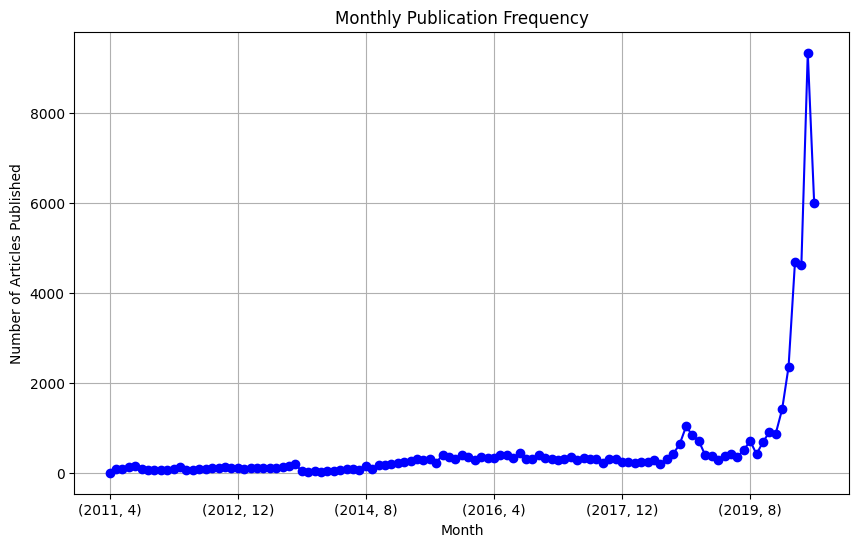


Potential Spikes in Publication Frequency:
year  month
2018  10        393.0
2020  1         542.0
      2         939.0
      3        2324.0
      5        4717.0
      6        3343.0
dtype: float64


In [10]:
# How does the publication frequency vary over time? 

import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_path = "../assets/data/raw_analyst_ratings.csv"  # Replace with the actual path to your file
df = pd.read_csv(file_path)

# Ensure the dataset has a 'publication_date' column
if 'date' not in df.columns:
    raise ValueError("The dataset must contain a 'date' column.")

# Convert the 'publication_date' column to datetime format (adjust the column name if necessary)
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Drop rows with invalid or missing publication dates
df = df.dropna(subset=['date'])

# Extract year, month, and day for time-based analysis
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

# Step 1: Count the number of publications per month (or any time period you want)
monthly_publications = df.groupby(['year', 'month']).size()

# Plot the number of publications per month
plt.figure(figsize=(10, 6))
monthly_publications.plot(kind='line', marker='o', color='b')
plt.title('Monthly Publication Frequency')
plt.xlabel('Month')
plt.ylabel('Number of Articles Published')
plt.grid(True)
plt.show()

# Step 2: Identify spikes in publication frequency
# Find the months with the largest change in publication frequency
monthly_diff = monthly_publications.diff().abs()  # Difference in number of publications
spikes = monthly_diff[monthly_diff > monthly_diff.quantile(0.95)]  # Top 5% of spikes

print("\nPotential Spikes in Publication Frequency:")
print(spikes)

# If you want to analyze spikes during specific market events, you could cross-reference the spikes with event dates.


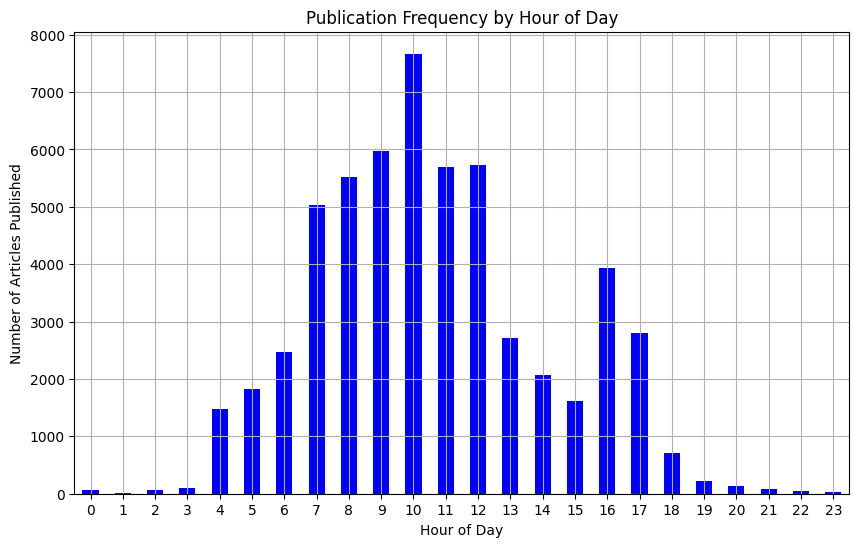


Peak Publication Hours:
hour
10    7669
dtype: int64


In [11]:
# Analysis of publishing times might reveal if there’s a specific time when most news is released, 

import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_path = "../assets/data/raw_analyst_ratings.csv"  # Replace with your actual file path
df = pd.read_csv(file_path)

# Ensure the dataset has a 'publication_date' column
if 'date' not in df.columns:
    raise ValueError("The dataset must contain a 'date' column.")

# Convert the 'publication_date' column to datetime format (adjust the column name if necessary)
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Drop rows with invalid or missing publication dates
df = df.dropna(subset=['date'])

# Step 1: Extract the hour of publication
df['hour'] = df['date'].dt.hour

# Step 2: Count the number of publications per hour
hourly_publications = df.groupby('hour').size()

# Step 3: Visualize the distribution of publications by hour
plt.figure(figsize=(10, 6))
hourly_publications.plot(kind='bar', color='b')
plt.title('Publication Frequency by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Articles Published')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

# Step 4: Identify peaks in the publication frequency
peaks = hourly_publications[hourly_publications == hourly_publications.max()]

print("\nPeak Publication Hours:")
print(peaks)


## Publisher Analysis:

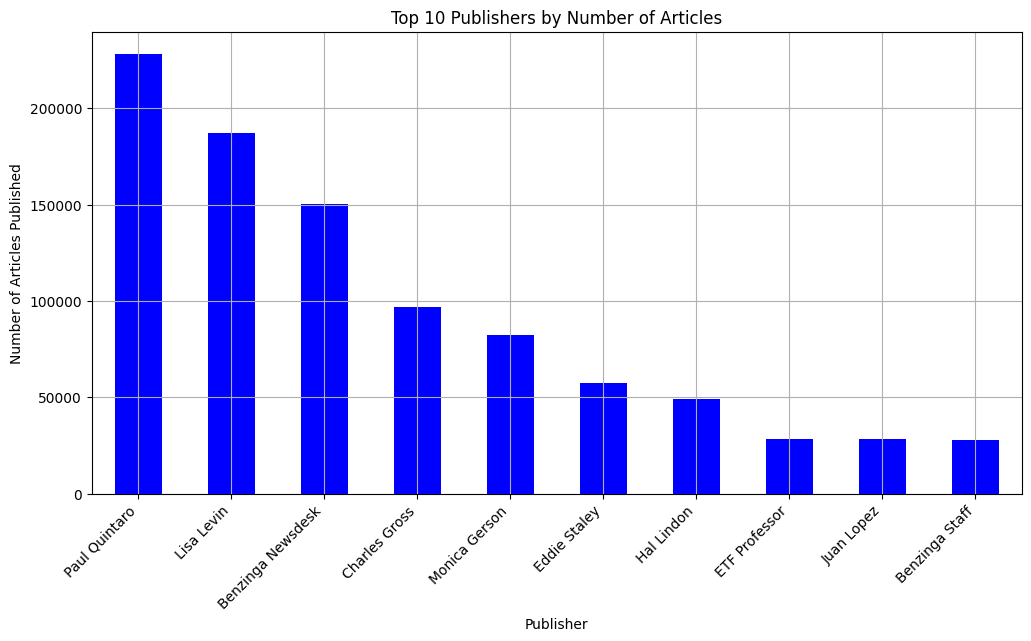

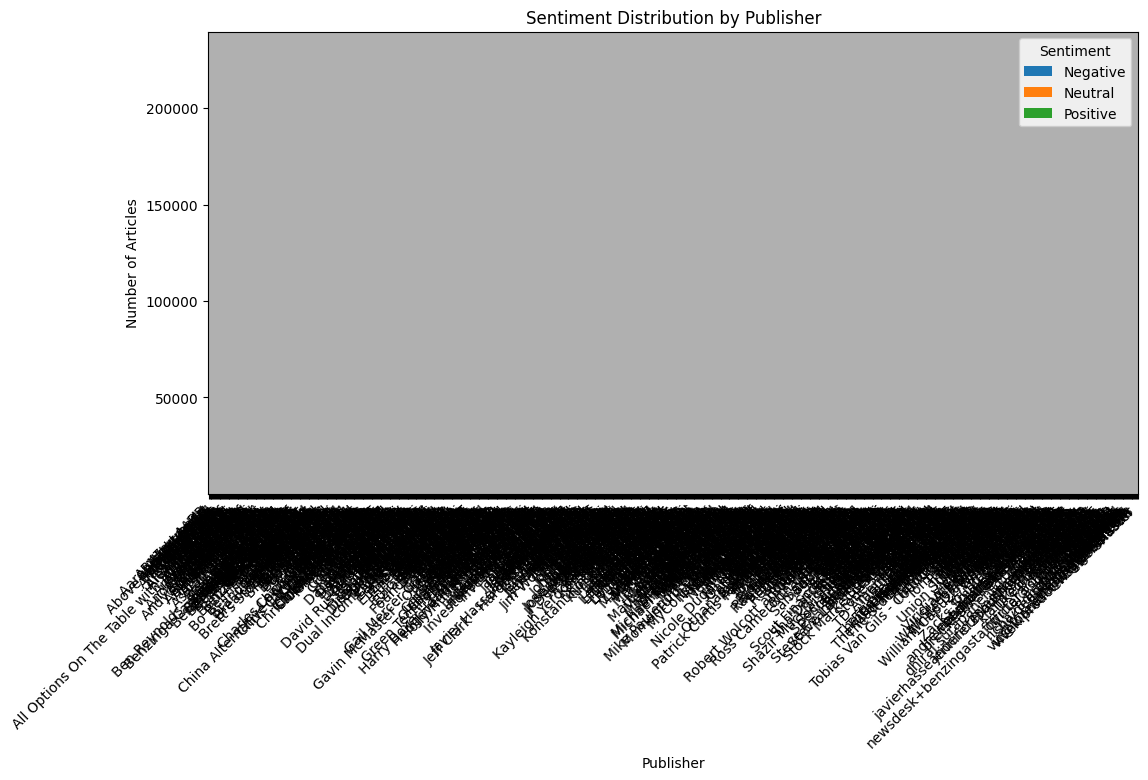

Top 10 keywords for Paul Quintaro:
['00' 'announces' 'eps' 'est' 'pt' 'reports' 'sales' 'sees' 'shares' 'vs']


In [12]:
# Which publishers contribute most to the news feed? Is there a difference in the type of news they report?

import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob

# Load the dataset
file_path = "../assets/data/raw_analyst_ratings.csv"  # Replace with your actual file path
df = pd.read_csv(file_path)

# Ensure the dataset has the necessary columns: 'publisher' and 'headline'
if 'publisher' not in df.columns or 'headline' not in df.columns:
    raise ValueError("The dataset must contain 'publisher' and 'headline' columns.")

# Step 1: Count articles by publisher
publisher_counts = df['publisher'].value_counts()

# Plot the number of articles per publisher
plt.figure(figsize=(12, 6))
publisher_counts.head(10).plot(kind='bar', color='b')  # Top 10 publishers
plt.title('Top 10 Publishers by Number of Articles')
plt.xlabel('Publisher')
plt.ylabel('Number of Articles Published')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()

# Step 2: Sentiment Analysis by Publisher
def analyze_sentiment(headline):
    analysis = TextBlob(headline)
    polarity = analysis.polarity  # Sentiment polarity: -1 (negative) to +1 (positive)
    if polarity > 0:
        return "Positive"
    elif polarity < 0:
        return "Negative"
    else:
        return "Neutral"

# Apply sentiment analysis to the headlines
df['sentiment'] = df['headline'].apply(analyze_sentiment)

# Group by publisher and get sentiment counts
sentiment_by_publisher = df.groupby(['publisher', 'sentiment']).size().unstack().fillna(0)

# Plot sentiment distribution by publisher
sentiment_by_publisher.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Sentiment Distribution by Publisher')
plt.xlabel('Publisher')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment')
plt.grid(True)
plt.show()

# Step 3: Keyword Extraction by Publisher (using TF-IDF)
def get_top_keywords_by_publisher(df, publisher_name, top_n=10):
    publisher_data = df[df['publisher'] == publisher_name]
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=top_n)
    X_tfidf = tfidf_vectorizer.fit_transform(publisher_data['headline'])
    return tfidf_vectorizer.get_feature_names_out()

# Get top 10 keywords for the top publisher
top_publisher = publisher_counts.index[0]
top_keywords = get_top_keywords_by_publisher(df, top_publisher)

print(f"Top 10 keywords for {top_publisher}:")
print(top_keywords)



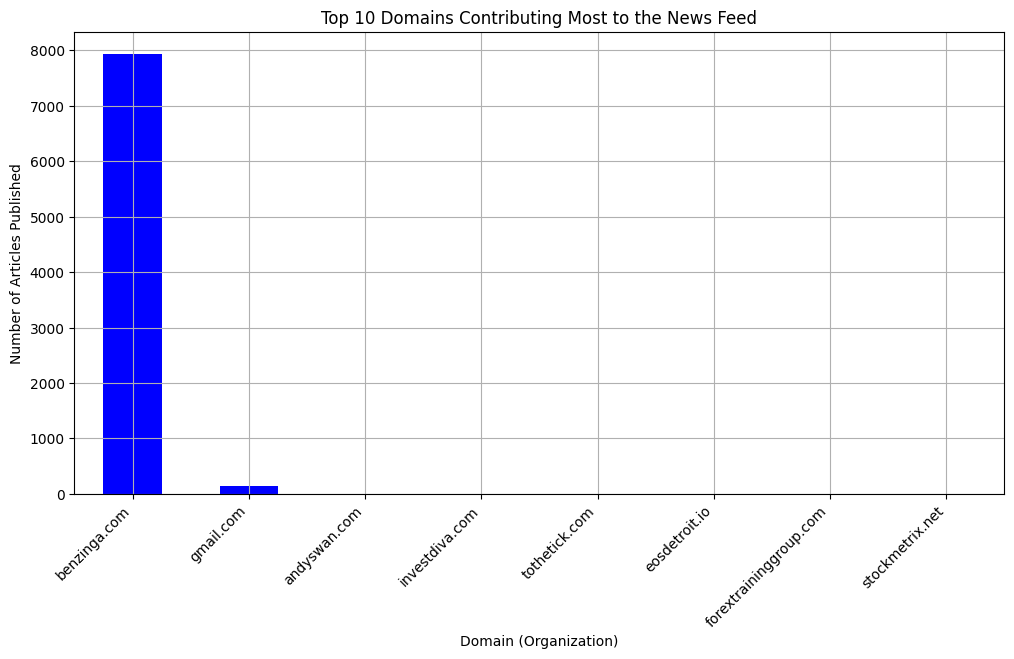


Top Domains by Frequency:
domain
benzinga.com              7937
gmail.com                  139
andyswan.com                 5
investdiva.com               2
tothetick.com                2
eosdetroit.io                1
forextraininggroup.com       1
stockmetrix.net              1
Name: count, dtype: int64


In [13]:
# If email addresses are used as publisher names, identify unique domains to see if certain organizations contribute more frequently.

import pandas as pd
import matplotlib.pyplot as plt
import re

# Load the dataset
file_path = "../assets/data/raw_analyst_ratings.csv"  # Replace with your actual file path
df = pd.read_csv(file_path)

# Ensure the dataset has the necessary 'publisher' column
if 'publisher' not in df.columns:
    raise ValueError("The dataset must contain a 'publisher' column.")

# Step 1: Extract domain from email addresses
def extract_domain(email):
    # Use regex to extract the domain part after '@'
    match = re.search(r'@([A-Za-z0-9.-]+)', email)
    if match:
        return match.group(1)
    else:
        return None  # Return None if there's no valid domain

# Apply the extract_domain function to the 'publisher' column
df['domain'] = df['publisher'].apply(extract_domain)

# Step 2: Count occurrences of each domain
domain_counts = df['domain'].value_counts()

# Step 3: Visualize the top domains (top 10)
plt.figure(figsize=(12, 6))
domain_counts.head(10).plot(kind='bar', color='b')
plt.title('Top 10 Domains Contributing Most to the News Feed')
plt.xlabel('Domain (Organization)')
plt.ylabel('Number of Articles Published')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()

# Optional: Print the most frequent domains
print("\nTop Domains by Frequency:")
print(domain_counts.head(10))
